# 使用前，需要先导入需要的头文件

In [1]:
#include <iostream>

/*a workaround to solve cling issue*/
#include "../inc/macos_cling_workaround.hpp"
/*set libtorch path, load libs*/
#include "../inc/load_libtorch.hpp"
/*import custom defined macros*/
#include "../inc/custom_def.hpp"
/*import matplotlibcpp*/
#include "../inc/load_matplotlibcpp.hpp"

/*import libtorch header file*/
#include <torch/torch.h>

---

***此处仅为随堂笔记，详情请参考[公开课教程](http://courses.d2l.ai/zh-v2/)***

- [2021.03.27 13:05]  
    首次直播：北京时间 2021.03.27，13:00 pm  
    机器之心首播，B站录播地址随后附上；   
    ***[公开课讲义1](http://courses.d2l.ai/zh-v2/assets/pdfs/part-0_8.pdf)***    
    ***[公开课讲义2](http://courses.d2l.ai/zh-v2/assets/pdfs/part-0_9.pdf)***

# 1.线性回归介绍

从美国买房谈起；
1.看房;
2.出价；


- 从一个简化模型讲起：  
假设1：影响房价的因素有卧室个数，卫生间个数和居住面积，记为$x_1$，$x_2$，$x_3$；  
假设2：成交价是影响因素的加权和：$y = w_1*x_1 + w_2*x_2 + w_3*x_3 + b$


给定n维输入 $\large{\textbf{x}} = {[x_1, x_2, ..., x_n]}^T$；  
针对n维权重和一个标量偏差： $\large{\textbf{w}} = {[w_1, w_2, ..., w_n]^T,   b}$

会得到一个输出$y$：  
$y = w_1*x_1 + w_2*x_2 +\ ...\ + w_n*x_n + b$    

用向量表示就是  
$y = \large{\textbf{<w,x>}} + b$


从上面公式可以得出，已知$\large{\textbf{w}}$和$b$，根据$\large{\textbf{x}}$，可以很容易估计出房屋价格$y$;

---
因为有了$\large{\textbf{w}}$和$\textbf{b}$，我们就可以很容易的去预测房价了。

因此现在的首要问题是，已知房屋价格$\hat{y}$和房价影响因素$\large{\textbf{x}}$，如何去求解$\large{\textbf{w}}$和$\textbf{b}$?

---

要求得最优$\large{\textbf{w}}$和$\textbf{b}$，则需要定义一个损失函数，使得我们预测的房价和真实房价的差最小（不一定是0）；  

定义损失函数$\mathscr{l(y, \hat{y})} = {|\hat{y} - y|^2}$  
这叫平方损失函数(且是凸函数，因此可以求得最优解)；(注：下面临时截图相关公式，后续有空再用LaTeX重写)

![解析解](./images/01.png)

# 2.优化算法

梯度下降：
$w_t = w_{t-1} - \eta * \frac{\partial{\mathscr{l}}}{\partial{w_{t-1}}}$  
即沿着梯度的反方向下降，更新$\large{w}$，使得损失值，t代表迭代轮次，$\eta$就是学习率。

小批量随机梯度下降；

# 3.线性回归从零开始实现

首先构造一个数据集，它是一个线性模型，同时，为了更接近实际情况，还需要加入随机噪声$\epsilon$：  
$y = \textbf{X*w} + b + \epsilon$  
此处我们假设$\text{w} = [2.0, -3.4]^T,  b = 4.2$

In [2]:
typedef std::tuple<torch::Tensor, torch::Tensor> sample_set;

In [3]:
sample_set synthetic_data(torch::Tensor w, torch::Tensor b, int num_example)
{
    torch::Tensor X = torch::normal(0.0, 1.0, {num_example, w.size(0)}); 
    torch::Tensor y = X.matmul(w) + b;
    y = y + torch::normal(0.0, 0.1, y.sizes());
    
    return std::make_tuple(X, y);
}

In [9]:
float coe[] = {2.0, 3.4};
float bias[] = {4.2};

/** calling 'from_blob(...)' may cause compile error with my
 *  xeus-clilng enviroment, so here I changed it with another
 *  way; but maybe you can try it in your pc;
 */
// torch::Tensor true_w = torch::from_blob(coe, {2, 1});
// torch::Tensor true_b = torch::from_blob(bias, {1});

torch::Tensor true_w = torch::tensor(at::ArrayRef<float>({2.0, 3.4}));
torch::Tensor true_b = torch::tensor(at::ArrayRef<float>({4.2}));
sample_set data = synthetic_data(true_w, true_b, 10);

printT(std::get<0>(data));

std::get<0>(data) = 
 0.2979 -0.6322
 1.0754  1.0289
-0.1738  0.9695
-0.0444 -0.8169
-0.0508 -1.4010
-0.9827 -0.2543
-1.4146 -0.8959
-1.7175  1.6052
-2.3462  0.5749
-0.3612 -1.1753
[ CPUFloatType{10,2} ]
<<--->>



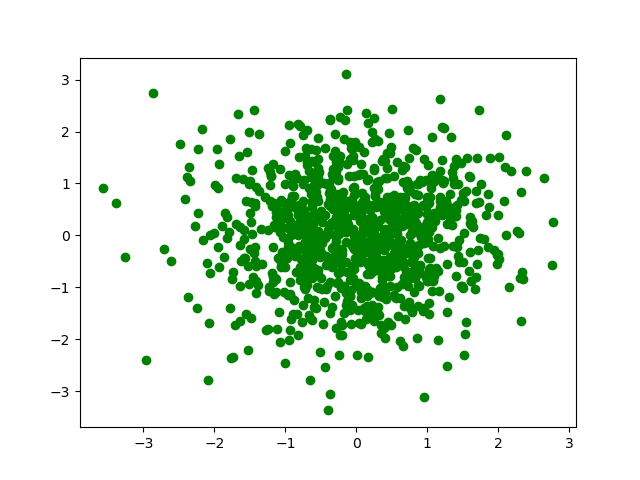

In [5]:
#define DSIZE 100
sample_set tdata = synthetic_data(true_w, true_b, DSIZE);

std::vector<float> x, y;
torch::Tensor t = std::get<0>(tdata);
for (int i = 0; i < DSIZE; i++) {
  x.push_back(t[i][0].item<float>());
  y.push_back(t[i][1].item<float>());
}


plt::plot(x, y, "og");
plt::save("./test2.png");
auto img = im::image("./test2.png");
img